In [1]:
from Bio import SeqIO
import pandas as pd
import torch
from tape import ProteinBertModel, TAPETokenizer
from Bio.Alphabet import IUPAC
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import torch
from tape import ProteinBertModel, TAPETokenizer

import numpy as np
import pandas as pd
import json

from sklearn.linear_model import LogisticRegression
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import to_categorical

Using TensorFlow backend.
/Users/thomaswaldschmidt/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/thomaswaldschmidt/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/thomaswaldschmidt/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/thomaswaldschmid

### Data Loading

In [29]:
model = ProteinBertModel.from_pretrained('bert-base')
tokenizer = TAPETokenizer(vocab='iupac')

lookup_d = {}
seq_list = []
loc_list = []
count = 0
for record in SeqIO.parse("data/deeploc_data_1024.fasta", "fasta"):
    description = record.description
    seq = record.seq
    seq_list.append(len(str(seq)))
    count += 1
    desc_split = description.split(" ")
    loc_list.append(desc_split[:len(desc_split)-2])
    if len(desc_split) == 3:
        ID = desc_split[0]
        label = desc_split[1]
        label = label[:len(label)-2]
        if label == "Cytoplasm-Nucleus":
            label = "Cytplasm"
        lookup_d[ID] = label
    
    else:
        ID = desc_split[0]
        label = desc_split[1]
        label = label[:len(label)-2]
        if label == "Cytoplasm-Nucleus":
            label = "Cytoplasm"
        lookup_d[ID] = label

In [43]:
seq_df = pd.DataFrame(seq_list)
loc_df = pd.DataFrame(loc_list)
sub_cellular_df = pd.merge(left=loc_df, right=seq_df,how='inner',left_index=True,right_index=True)
#label_df=pd.DataFrame.from_dict(lookup_d,orient='index')
#print(loc_df.shape)
sub_cellular_df=sub_cellular_df.rename(columns= {'0_x':'ID', 1:'Location',2:'TBD','0_y':'Seq Length'})
seq_df.describe(percentiles=[.91, .95, .99])

,0
count,12704.000000
mean,418.507793
std,234.958061
min,40.000000
50%,389.000000
91%,781.000000
95%,873.000000
99%,988.970000
max,1024.000000


In [49]:
sub_cellular_df.groupby('Location').mean()

,Seq Length
Location,
Cell.membrane-M,514.265132
Cytoplasm-Nucleus-U,488.544776
Cytoplasm-S,458.808905
Endoplasmic.reticulum-M,419.067153
Endoplasmic.reticulum-S,470.732143
Endoplasmic.reticulum-U,414.164557
Extracellular-S,250.955683
Golgi.apparatus-M,457.767606
Golgi.apparatus-S,422.500000


In [50]:
train_arrays = np.load('data/output_deeploc_train.npz', allow_pickle=True)
valid_arrays = np.load('data/output_deeploc_valid.npz', allow_pickle=True)
test_arrays = np.load('data/output_deeploc_test.npz', allow_pickle=True)

In [51]:
id_dict = {'Cell.membrane': 0, 
 'Cytoplasm': 1, 
 'Endoplasmic.reticulum': 2, 
 'Golgi.apparatus': 3, 
 'Lysosome/Vacuole': 4,
 'Mitochondrion': 5, 
 'Nucleus': 6,
 'Peroxisome': 7, 
 'Plastid': 8,
 'Extracellular': 9}


def gen_df(df, label_list, arrays):
    l = list(arrays.keys())
    labels = []
    for a in l:
        d = arrays[a].item()['avg']
        append_df = pd.DataFrame(d)
        labels.append(lookup_d[a])
        df = df.append(append_df.transpose(), ignore_index=True)
    return df, labels

train_df, train_labels = gen_df(pd.DataFrame(), [], train_arrays)
valid_df, valid_labels = gen_df(pd.DataFrame(), [], valid_arrays)
test_df, test_labels = gen_df(pd.DataFrame(), [], test_arrays)

### Logistic Regression

In [57]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


Automatically created module for IPython interactive environment


In [78]:
train_valid_df = train_df.append(valid_df, ignore_index=True)
train_valid_labels = train_labels + valid_labels

In [79]:
train_y = [id_dict[label] for label in train_valid_labels]
test_y = [id_dict[label] for label in test_labels]
#test_lab = [id_dict[label] for label in test_labels]

In [81]:
# Binarize the output
y_train = label_binarize(train_y, classes=[0, 1, 2,3,4,5,6,7,8,9])
y_test = label_binarize(test_y, classes=[0, 1, 2,3,4,5,6,7,8,9])
n_classes = y_test.shape[1]

In [114]:
clf = OneVsRestClassifier(LogisticRegression(solver='newton-cg',random_state=42,multi_class='multinomial'))
y_score = clf.fit(train_valid_df, y_train).decision_function(test_df)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



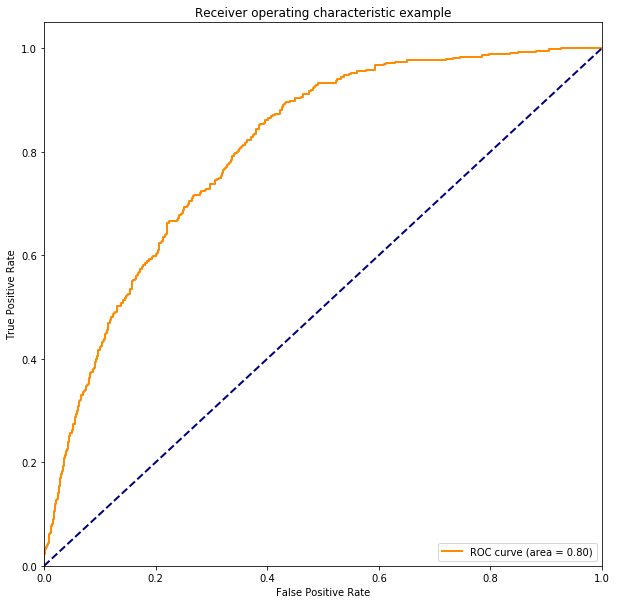

In [108]:
plt.figure(figsize=(10,10))
subclass=2
lw = 2
plt.plot(fpr[subclass], tpr[subclass], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[subclass])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

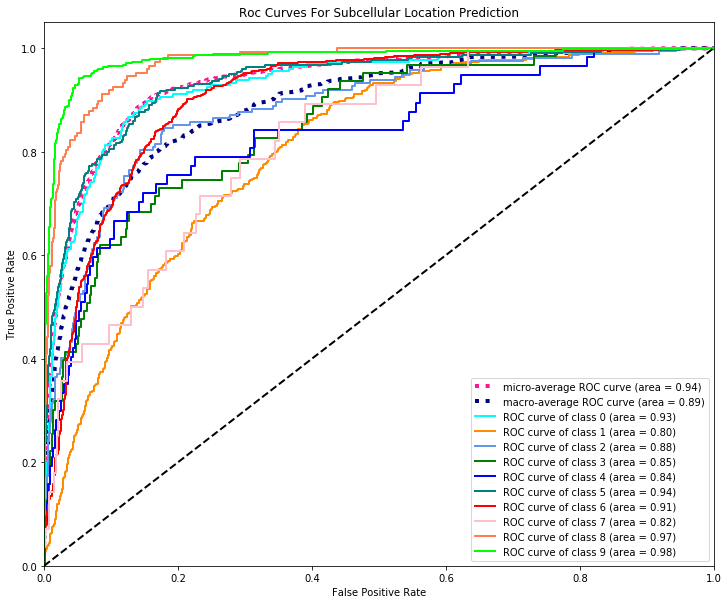

In [117]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(12,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue','green','blue','teal','red','pink','coral','lime'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc Curves For Subcellular Location Prediction')
plt.legend(loc="lower right")
plt.show()

In [111]:
clf.score(train_valid_df, y_train)

0.6770690667188417

In [112]:
clf.score(test_df, y_test)

0.5171009771986971

### Keras DNN

In [53]:
train_lab = [id_dict[label] for label in train_labels]
valid_lab = [id_dict[label] for label in valid_labels]
test_lab = [id_dict[label] for label in test_labels]

In [79]:
model = Sequential()
model.add(Dense(32, input_dim=768, activation='softmax'))
model.add(Dense(32, activation='softmax'))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [80]:
history = model.fit(train_df, to_categorical(train_lab), 
          validation_data=(valid_df, to_categorical(valid_lab)),
          epochs=200, batch_size=64)

Train on 9220 samples, validate on 1002 samples
Epoch 1/200
9220/9220 [==============================] - 1s 133us/step - loss: 2.2197 - acc: 0.2502 - val_loss: 2.1492 - val_acc: 0.2844
Epoch 2/200
9220/9220 [==============================] - 0s 41us/step - loss: 2.0988 - acc: 0.2734 - val_loss: 2.0491 - val_acc: 0.2844
Epoch 3/200
9220/9220 [==============================] - 0s 44us/step - loss: 2.0094 - acc: 0.2734 - val_loss: 1.9603 - val_acc: 0.3603
Epoch 4/200
9220/9220 [==============================] - 0s 44us/step - loss: 1.9184 - acc: 0.4081 - val_loss: 1.8659 - val_acc: 0.3972
Epoch 5/200
9220/9220 [==============================] - 0s 39us/step - loss: 1.8253 - acc: 0.4132 - val_loss: 1.7772 - val_acc: 0.3992
Epoch 6/200
9220/9220 [==============================] - 0s 42us/step - loss: 1.7439 - acc: 0.4150 - val_loss: 1.7042 - val_acc: 0.3982
Epoch 7/200
9220/9220 [==============================] - 0s 44us/step - loss: 1.6846 - acc: 0.4146 - val_loss: 1.6639 - val_acc: 0.3992

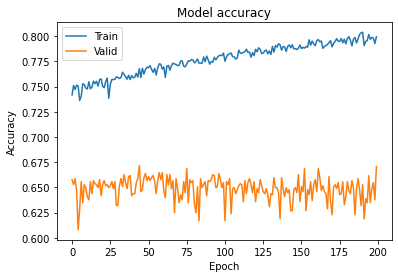

In [77]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [76]:
model.evaluate(test_df, to_categorical(test_lab))

2456/2456 [==============================] - 0s 24us/step


[1.3570286637408726, 0.617671009577835]